In [8]:
#Import Libraries
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns


In [9]:
# load dataset
customer_df = pd.read_csv('customer_details.csv')
sales_df = pd.read_csv('E-commerece sales data 2024.csv')
product_df = pd.read_csv('product_details.csv')


In [10]:
sales_df.info()
sales_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3294 entries, 0 to 3293
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user id           2999 non-null   float64
 1   product id        2999 non-null   object 
 2   Interaction type  2871 non-null   object 
 3   Time stamp        2999 non-null   object 
 4   Unnamed: 4        0 non-null      float64
dtypes: float64(2), object(3)
memory usage: 128.8+ KB


,user id,product id,Interaction type,Time stamp,Unnamed: 4
0,1.0,4c69b61db1fc16e7013b43fc926e502d,purchase,10/10/2023 8:00,NaN
1,2.0,66d49bbed043f5be260fa9f7fbff5957,view,11/10/2023 8:00,NaN
2,3.0,2c55cae269aebf53838484b0d7dd931a,like,12/10/2023 8:00,NaN
3,4.0,18018b6bc416dab347b1b7db79994afa,view,13/10/2023 8:00,NaN
4,5.0,e04b990e95bf73bbe6a3fa09785d7cd0,like,14/10/2023 8:00,NaN


In [11]:
# Drop the useless column
sales_df = sales_df.drop(columns=['Unnamed: 4'])

# Drop rows with missing user id or timestamp
sales_df = sales_df.dropna(subset=['user id', 'Time stamp'])

# Convert user id to integer
sales_df['user id'] = sales_df['user id'].astype(int)

# Convert Time stamp to datetime
sales_df['Time stamp'] = pd.to_datetime(sales_df['Time stamp'], format="%d/%m/%Y %H:%M")

# Filter only 'purchase' interactions for RFM
purchase_df = sales_df[sales_df['Interaction type'] == 'purchase']

# Preview
purchase_df.head()


,user id,product id,Interaction type,Time stamp
0,1,4c69b61db1fc16e7013b43fc926e502d,purchase,2023-10-10 08:00:00
6,7,40d3cd16b41970ae6872e914aecf2c8e,purchase,2023-10-16 08:00:00
9,10,69828c5570dcdbd1609216d33fbad0db,purchase,2023-10-19 08:00:00
10,11,7b0746d8afc8462ba17f8a763d9d5f1e,purchase,2023-10-20 08:00:00
16,17,d82015ffbf4cd54b0edfb890002971f3,purchase,2023-10-26 08:00:00


In [12]:
snapshot_date = purchase_df['Time stamp'].max() + pd.Timedelta(days=1)
print("Snapshot date:", snapshot_date)


Snapshot date: 2023-12-29 08:00:00


In [13]:
rfm = purchase_df.groupby('user id').agg({
    'Time stamp': lambda x: (snapshot_date - x.max()).days,
    'product id': 'count'  # Number of purchases = frequency
})

# Rename columns
rfm.rename(columns={
    'Time stamp': 'Recency',
    'product id': 'Frequency'
}, inplace=True)

# Assume Monetary = Frequency (since we don't have prices)
rfm['Monetary'] = rfm['Frequency']

rfm.head()


,Recency,Frequency,Monetary
user id,,,
1,80,1,1
7,74,1,1
10,71,1,1
11,70,1,1
17,64,1,1


In [15]:
# Rank before qcut to avoid duplicate bin edges
rfm['R'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])
rfm['F'] = pd.qcut(rfm['Frequency'].rank(method="first"), 5, labels=[1,2,3,4,5])
rfm['M'] = pd.qcut(rfm['Monetary'].rank(method="first"), 5, labels=[1,2,3,4,5])  # FIXED

# Combine scores
rfm['RFM_Score'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)
rfm.head()


,Recency,Frequency,Monetary,R,F,M,RFM_Score
user id,,,,,,,
1,80,1,1,3,1,1,311
7,74,1,1,3,1,1,311
10,71,1,1,3,1,1,311
11,70,1,1,3,1,1,311
17,64,1,1,3,1,1,311


In [16]:
def segment_customer(score):
    if score >= '444':
        return 'Champions'
    elif score >= '344':
        return 'Loyal Customers'
    elif score >= '244':
        return 'Potential Loyalist'
    elif score >= '144':
        return 'Needs Attention'
    else:
        return 'At Risk'

rfm['Segment'] = rfm['RFM_Score'].apply(segment_customer)
rfm['Segment'].value_counts()


,count
Segment,
Champions,229
Potential Loyalist,210
Loyal Customers,188
At Risk,124
Needs Attention,104


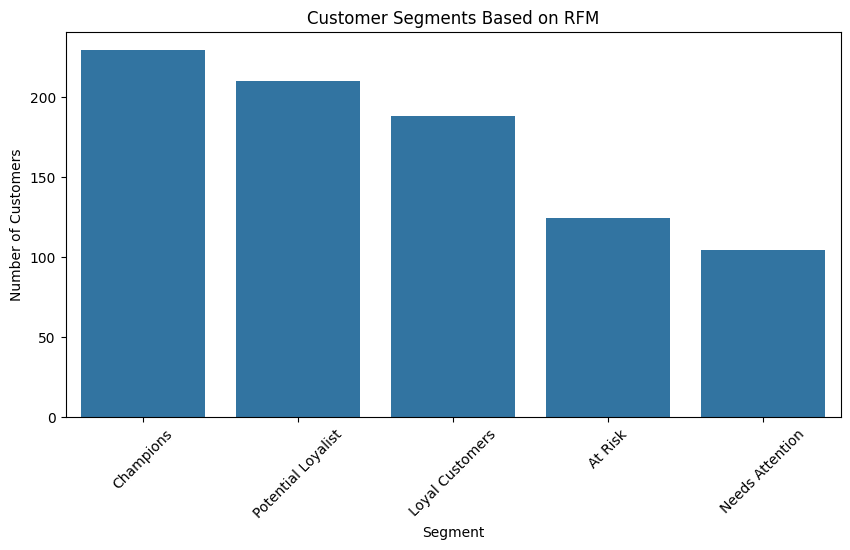

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index)
plt.title("Customer Segments Based on RFM")
plt.xlabel("Segment")
plt.ylabel("Number of Customers")
plt.xticks(rotation=45)
plt.show()
